In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import pickle # for pickle.load()
%matplotlib inline


Using TensorFlow backend.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
for i in range(n_gpu):
    print('GPU',i,': ', torch.cuda.get_device_name(i), '\n')

GPU 0 :  Tesla V100-SXM2-16GB 

GPU 1 :  Tesla V100-SXM2-16GB 

GPU 2 :  Tesla V100-SXM2-16GB 

GPU 3 :  Tesla V100-SXM2-16GB 



In [3]:
DATA_DIR="."

# load Pickle file 
def load_ds(fname=os.path.join(DATA_DIR,'/atis.train.pkl'), verbose=True):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    if verbose:
      print('Done  loading: ', fname)
      print('      samples: {:4d}'.format(len(ds['query'])))
      print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
      print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
      print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts
  
# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, \
        query_data, intent_data, intent_data_label, slot_data


In [4]:
# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')


Done  loading:  ./atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS i would like a list of round trip flights between indianapolis and orlando florida for the twenty seventh and the twenty eighth of december EOS
Query vector:  [178 479 932 545 180 549 646 730 870 429 259 489 215 667 430 435 827 881
 766 215 827 881 394 646 348 179]
Intent label:  flight
Slot text:  O O O O O O O B-round_trip I-round_trip O O B-fromloc.city_name O B-toloc.city_name B-toloc.state_name O O B-depart_date.day_number I-depart_date.day_number O O B-depart_date.day_number I-depart_date.day_number O B-depart_date.month_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 66, 119, 128, 128, 48, 128, 78, 81, 128, 128, 27, 95, 128, 128, 27, 95, 128, 28, 128]
**************************************************************************
Query text: BOS what are the lowest one way fares from atlanta to denver EOS
Query vector:  [178 916 228 827 566 656 906

In [5]:
set(zip(intent_data_train, intent_data_label_train))

{('abbreviation', 0),
 ('aircraft', 1),
 ('aircraft+flight+flight_no', 2),
 ('airfare', 3),
 ('airfare+flight_time', 5),
 ('airline', 6),
 ('airline+flight_no', 7),
 ('airport', 8),
 ('capacity', 9),
 ('cheapest', 10),
 ('city', 11),
 ('distance', 13),
 ('flight', 14),
 ('flight+airfare', 15),
 ('flight_no', 17),
 ('flight_time', 19),
 ('ground_fare', 20),
 ('ground_service', 21),
 ('ground_service+ground_fare', 22),
 ('meal', 23),
 ('quantity', 24),
 ('restriction', 25)}

([<matplotlib.axis.XTick at 0x2aab5a413110>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

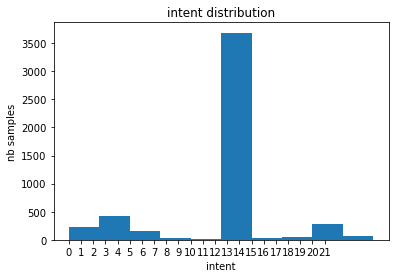

In [6]:
labels = intent_data_label_train
plt.hist(labels)
plt.xlabel('intent')
plt.ylabel('nb samples')
plt.title('intent distribution')
plt.xticks(np.arange(len(np.unique(labels))))


([<matplotlib.axis.XTick at 0x2aab5a681c10>,
 [Text(0, 0, ''), Text(0, 0, '')])

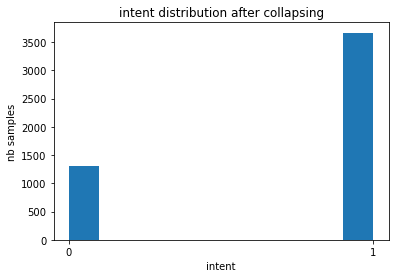

In [7]:
labels[labels==14] = -1
labels[labels!=-1] = 0
labels[labels==-1] = 1

plt.hist(labels)
plt.xlabel('intent')
plt.ylabel('nb samples')
plt.title('intent distribution after collapsing')
plt.xticks(np.arange(len(np.unique(labels))))


In [8]:
# correct intent labels are stored in the variable labels

# add special tokens for BERT to work properly
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


[CLS]  i want to fly from boston at 838 am and arrive in denver at 1110 in the morning  [SEP]
Tokenize the first sentence:
['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']


In [9]:
# Set the maximum sequence length. 
MAX_LEN = 128

In [10]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# `pad_sequences()` transforms a list of num_samples sequences (lists of integers) 
## into a 2D Numpy array of shape (num_samples, num_timesteps)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [11]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding (0's in the padded sequence will be omitted)
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq] # float to make sure the mask in tensor use same type
  attention_masks.append(seq_mask)
print(attention_masks[0])


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [12]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [13]:
nb_labels = len(set(labels))
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=nb_labels)
model.cuda()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [14]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)


t_total value of -1 results in schedule not being applied


In [15]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  

In [16]:
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Epoch:  25%|██▌       | 1/4 [00:48<02:24, 48.21s/it]Validation Accuracy: 0.984375
Train loss: 0.02263612117302338
Epoch:  50%|█████     | 2/4 [01:36<01:36, 48.36s/it]Validation Accuracy: 0.9921875
Train loss: 0.009173206952566813
Epoch:  75%|███████▌  | 3/4 [02:24<00:48, 48.27s/it]Validation Accuracy: 0.9921875
Train loss: 0.007050101620344711
Epoch: 100%|██████████| 4/4 [03:13<00:00, 48.45s/it]Validation Accuracy: 0.994140625



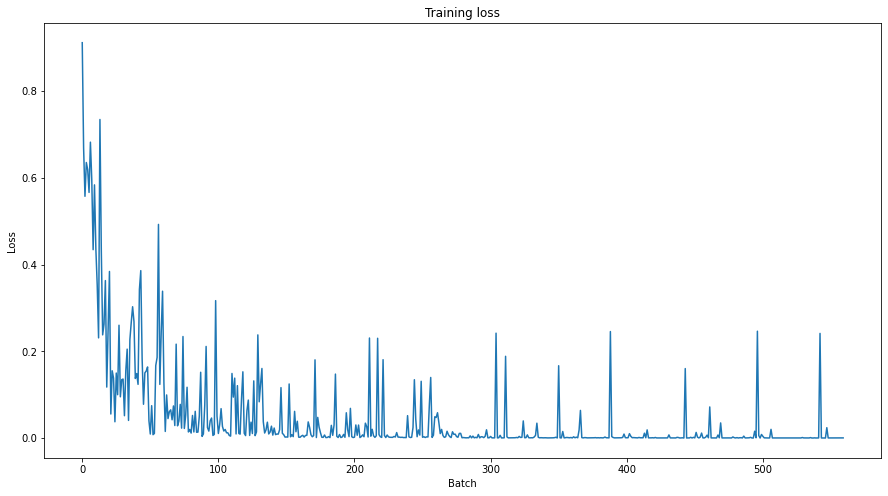

In [17]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()


In [18]:
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_test]
labels = intent_data_label_test

labels[labels==14] = -1
labels[labels!=-1] = 0
labels[labels==-1] = 1

# tokenize test data
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  

In [19]:
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [20]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
 
print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))

Classification accuracy using BERT Fine Tuning: 95.38%
